# Titanic Survival Prediction Model - v08 (XGBoost - Enhanced FE - No SMOTE Fine Tuning - Scoring Accuracy)

This notebook builds on v05, using **XGBoost** to predict passenger survival.

**Goal:** Predict "who is more likely to survive?" with improved feature engineering for better generalization, using `roc_auc` as the primary evaluation metric.

**Changes from v05:**
*   **Focus:** Enhanced Feature Engineering and Data Handling.
*   **New Features:**
    *   `TicketFrequency`: Number of people sharing the same ticket.
    *   `TicketPrefix`: Extracted prefix from the 'Ticket' column.
    *   `Fare_log`: Log-transformed 'Fare' to handle skewness before binning.
    *   `FarePerPerson`: Calculated Fare divided by `TicketFrequency`.
    *   `CabinMultiple`: Number of cabins a passenger is listed for.
    *   Interaction Features: `Pclass_Sex`, `AgeBin_Pclass`.
*   **Improved Preprocessing:**
    *   Fare Imputation: Median fare per `Pclass`.
    *   Fare Binning: Applied to `Fare_log`.
*   **Evaluation Metric:** Changed `GridSearchCV` and diagnostic plots to use `scoring='roc_auc'`.

**Changes from v06:**
*   **Focus:** Running `GridSearchCV` with the possibility to test with and without SMOTE, to see which one performs the best.

**Changes from v07:**
*   **Focus:** Running `GridSearchCV` without SMOTE and scoring `Accuracy` in order to find the best params that generalize well on `Accuracy` even with `Data imbalance` since kaggles public and private LB use it as the validation score.
*   **New Analysis:** The overfitting analysis section will also use `Accuracy` as the evaluation metric to see the model performance

## 1. Setup - Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, validation_curve, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

# Import Colab specific tools for file handling
from google.colab import files

# Ignore minor warnings for cleaner output
warnings.filterwarnings('ignore')
# Display options for pandas
pd.set_option('display.max_columns', None) # Show all columns

print("Libraries imported successfully.")

Libraries imported successfully.


### Install Required Libraries (if not already present)

In [ ]:
!pip install -U imbalanced-learn xgboost
print("imbalanced-learn and xgboost check/installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
imbalanced-learn and xgboost check/installation complete.


## 2. Load Data

Upload `train.csv` and `test.csv` files.

In [ ]:
print("Please upload train.csv:")
uploaded_train = files.upload()

print("\nPlease upload test.csv:")
uploaded_test = files.upload()

# Load Files into DataFrames
import io

try:
    train_filename = list(uploaded_train.keys())[0]
    test_filename = list(uploaded_test.keys())[0]

    train_df = pd.read_csv(io.BytesIO(uploaded_train[train_filename]))
    test_df = pd.read_csv(io.BytesIO(uploaded_test[test_filename]))

    print("Successfully loaded train and test data.")
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")

    print("\nTraining Data Head:")
    display(train_df.head())

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure you uploaded the correct CSV files.")

Please upload train.csv:


Saving train.csv to train.csv

Please upload test.csv:


Saving test.csv to test.csv
Successfully loaded train and test data.
Train data shape: (891, 12)
Test data shape: (418, 11)

Training Data Head:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Combine Data for Preprocessing

In [ ]:
test_passenger_ids = test_df['PassengerId']
test_df['Survived'] = -1 # Placeholder for concatenation
full_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

print(f"Combined dataset shape: {full_df.shape}")
full_df.info()

Combined dataset shape: (1309, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


## 4. Feature Engineering & Preprocessing (Enhanced for v06)

This section includes new features and refined preprocessing steps.

### 4.1 Handle Missing Values & Basic Extractions

In [ ]:
# --- Extract Title from Name (Same as v05) ---
print("Extracting 'Title' from 'Name'...")
full_df['Title'] = full_df['Name'].apply(lambda name: re.search(' ([A-Za-z]+)\.', name).group(1))
common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
full_df['Title'] = full_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
full_df['Title'] = full_df['Title'].replace(['Mme'], 'Mrs')
full_df['Title'] = full_df['Title'].apply(lambda x: 'Rare' if x not in common_titles else x)
print("Value counts for 'Title':")
print(full_df['Title'].value_counts())

# --- Extract Deck from Cabin (Same as v05) ---
print("\nExtracting 'Deck' from 'Cabin'...")
full_df['Deck'] = full_df['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'M') # 'M' for Missing
print("Value counts for 'Deck':")
print(full_df['Deck'].value_counts())

# --- Create HasCabin (Same as v05) ---
full_df['HasCabin'] = full_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
print("\nCreated 'HasCabin' feature.")

# --- Age: Impute using median age per Title group (Same as v05) ---
print("\nImputing 'Age' based on median age per 'Title'...")
title_median_ages = full_df.groupby('Title')['Age'].median()
for title, median_age in title_median_ages.items():
    full_df.loc[(full_df['Age'].isnull()) & (full_df['Title'] == title), 'Age'] = median_age
if full_df['Age'].isnull().sum() > 0:
    overall_median_age = full_df['Age'].median()
    full_df['Age'].fillna(overall_median_age, inplace=True)
print(f"Missing 'Age' values remaining: {full_df['Age'].isnull().sum()}")

# --- Embarked: Fill missing with mode (Same as v05) ---
if full_df['Embarked'].isnull().sum() > 0:
    mode_embarked = full_df['Embarked'].mode()[0]
    full_df['Embarked'].fillna(mode_embarked, inplace=True)
    print(f"\nFilled missing 'Embarked' values with mode: {mode_embarked}")
else:
    print("\n'Embarked' has no missing values.")

# --- Fare: Impute missing 'Fare' with median Fare *per Pclass* (NEW v06) ---
print("\nImputing 'Fare' based on median fare per 'Pclass'...")
full_df['Fare'] = full_df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
# Fallback if any Pclass group itself had all NaNs (unlikely but safe)
if full_df['Fare'].isnull().sum() > 0:
    global_median_fare = full_df['Fare'].median()
    print(f"Still {full_df['Fare'].isnull().sum()} Fare NaNs, filling with global median: {global_median_fare:.2f}")
    full_df['Fare'].fillna(global_median_fare, inplace=True)
print(f"Missing 'Fare' values remaining: {full_df['Fare'].isnull().sum()}")

print("\nMissing values check after initial handling:")
print(full_df.isnull().sum()[full_df.isnull().sum() > 0].drop('Survived', errors='ignore'))

Extracting 'Title' from 'Name'...
Value counts for 'Title':
Title
Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: count, dtype: int64

Extracting 'Deck' from 'Cabin'...
Value counts for 'Deck':
Deck
M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

Created 'HasCabin' feature.

Imputing 'Age' based on median age per 'Title'...
Missing 'Age' values remaining: 0

Filled missing 'Embarked' values with mode: S

Imputing 'Fare' based on median fare per 'Pclass'...
Missing 'Fare' values remaining: 0

Missing values check after initial handling:
Cabin    1014
dtype: int64


### 4.2 Create New Features (v06 Enhancements)

In [ ]:
# --- FamilySize & IsAlone (Same as v05) ---
full_df['FamilySize'] = full_df['SibSp'] + full_df['Parch'] + 1
full_df['IsAlone'] = 0
full_df.loc[full_df['FamilySize'] == 1, 'IsAlone'] = 1
print("Created 'FamilySize' and 'IsAlone' features.")

# --- TicketFrequency (NEW v06) ---
print("\nCreating 'TicketFrequency' feature...")
full_df['TicketFrequency'] = full_df.groupby('Ticket')['Ticket'].transform('count')
print(full_df[['Ticket', 'TicketFrequency']].head())

# --- TicketPrefix (NEW v06) ---
print("\nCreating 'TicketPrefix' feature...")
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    parts = ticket.replace('.', '').replace('/', '').split()
    prefix = 'NUM' # Default for purely numeric tickets
    for part in parts:
        if not part.isdigit():
            prefix = part
            break
    return prefix
full_df['TicketPrefix'] = full_df['Ticket'].apply(extract_ticket_prefix)
# Consolidate rare prefixes
prefix_counts = full_df['TicketPrefix'].value_counts()
rare_prefixes = prefix_counts[prefix_counts < 10].index
full_df['TicketPrefix'] = full_df['TicketPrefix'].replace(rare_prefixes, 'RARE_TICKET')
print("Value counts for 'TicketPrefix':")
print(full_df['TicketPrefix'].value_counts().head(10))

# --- Fare_log (NEW v06) - Log transform Fare to handle skewness ---
print("\nCreating 'Fare_log' (log-transformed Fare)...")
full_df['Fare_log'] = np.log1p(full_df['Fare'])
print(full_df[['Fare', 'Fare_log']].head())

# --- FarePerPerson (NEW v06) ---
print("\nCreating 'FarePerPerson' feature...")
# Use TicketFrequency. If TicketFrequency is 0 (should not happen), or Fare is 0, result is 0 or NaN.
# Ensure TicketFrequency is at least 1 to avoid division by zero if Fare > 0.
full_df['FarePerPerson'] = full_df['Fare'] / full_df['TicketFrequency'].replace(0, 1) # Avoid division by zero
full_df['FarePerPerson_log'] = np.log1p(full_df['FarePerPerson']) # Also log transform this
print(full_df[['Fare', 'TicketFrequency', 'FarePerPerson', 'FarePerPerson_log']].head())

# --- Bin Age (Same as v05, using imputed Age) ---
print("\nBinning 'Age'...")
full_df['AgeBin'] = pd.cut(full_df['Age'], bins=[0, 12, 18, 35, 60, 81], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'], right=False)
print(full_df['AgeBin'].value_counts())

# --- Bin Fare_log (NEW v06, using Fare_log) ---
print("\nBinning 'Fare_log'...")
try:
    full_df['FareBin_log'] = pd.qcut(full_df['Fare_log'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')
except ValueError as e:
    print(f"Warning: qcut for Fare_log failed: {e}. Trying 5 bins.")
    try:
        full_df['FareBin_log'] = pd.qcut(full_df['Fare_log'], q=5, labels=['Lowest','Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')
    except Exception as e2:
        print(f"Error: qcut for Fare_log failed again: {e2}. Using pd.cut.")
        # Define bins based on Fare_log distribution if qcut fails
        fare_log_bins = np.percentile(full_df['Fare_log'][full_df['Fare_log'] > 0], [0, 25, 50, 75, 100])
        if fare_log_bins[0] > 0: fare_log_bins = np.insert(fare_log_bins, 0, 0)
        else: fare_log_bins[0] = 0 # Ensure start from 0 for log1p
        fare_log_bins = np.unique(fare_log_bins) # Ensure unique bin edges
        if len(fare_log_bins) < 2: fare_log_bins = [0, full_df['Fare_log'].max()]
        full_df['FareBin_log'] = pd.cut(full_df['Fare_log'], bins=fare_log_bins, labels=[f'Bin{i}' for i in range(len(fare_log_bins)-1)], include_lowest=True, duplicates='drop')

if full_df['FareBin_log'].isnull().sum() > 0:
     print(f"Warning: {full_df['FareBin_log'].isnull().sum()} NaNs created in FareBin_log, filling with lowest category.")
     lowest_fare_bin = full_df['FareBin_log'].cat.categories[0]
     full_df['FareBin_log'].fillna(lowest_fare_bin, inplace=True)
print("Value counts for 'FareBin_log':")
print(full_df['FareBin_log'].value_counts())

# --- CabinMultiple (NEW v06) ---
print("\nCreating 'CabinMultiple' feature...")
full_df['CabinMultiple'] = full_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
print(full_df['CabinMultiple'].value_counts())

# --- Interaction Features (NEW v06) ---
print("\nCreating interaction features...")
full_df['Pclass_Sex'] = full_df['Pclass'].astype(str) + "_" + full_df['Sex']
full_df['AgeBin_Pclass'] = full_df['AgeBin'].astype(str) + "_" + full_df['Pclass'].astype(str)
print("Value counts for 'Pclass_Sex':")
print(full_df['Pclass_Sex'].value_counts().head())
print("Value counts for 'AgeBin_Pclass':")
print(full_df['AgeBin_Pclass'].value_counts().head())

print("\nDataFrame head after adding new features:")
display(full_df[['TicketFrequency', 'TicketPrefix', 'Fare_log', 'FarePerPerson', 'FarePerPerson_log', 'AgeBin', 'FareBin_log', 'CabinMultiple', 'Pclass_Sex', 'AgeBin_Pclass']].head())

Created 'FamilySize' and 'IsAlone' features.

Creating 'TicketFrequency' feature...
             Ticket  TicketFrequency
0         A/5 21171                1
1          PC 17599                2
2  STON/O2. 3101282                1
3            113803                2
4            373450                1

Creating 'TicketPrefix' feature...
Value counts for 'TicketPrefix':
TicketPrefix
NUM            957
PC              92
RARE_TICKET     87
CA              68
A5              28
SOTONOQ         24
WC              15
STONO           14
SCPARIS         14
A4              10
Name: count, dtype: int64

Creating 'Fare_log' (log-transformed Fare)...
      Fare  Fare_log
0   7.2500  2.110213
1  71.2833  4.280593
2   7.9250  2.188856
3  53.1000  3.990834
4   8.0500  2.202765

Creating 'FarePerPerson' feature...
      Fare  TicketFrequency  FarePerPerson  FarePerPerson_log
0   7.2500                1        7.25000           2.110213
1  71.2833                2       35.64165           3.601186


,TicketFrequency,TicketPrefix,Fare_log,FarePerPerson,FarePerPerson_log,AgeBin,FareBin_log,CabinMultiple,Pclass_Sex,AgeBin_Pclass
0,1,A5,2.110213,7.25000,2.110213,YoungAdult,Low,0,3_male,YoungAdult_3
1,2,PC,4.280593,35.64165,3.601186,Adult,VeryHigh,1,1_female,Adult_1
2,1,RARE_TICKET,2.188856,7.92500,2.188856,YoungAdult,Medium,0,3_female,YoungAdult_3
3,2,NUM,3.990834,26.55000,3.316003,Adult,VeryHigh,1,1_female,Adult_1
4,1,NUM,2.202765,8.05000,2.202765,Adult,Medium,0,3_male,Adult_3


### 4.3 Convert Categorical Features

In [ ]:
# --- Label Encode Ordinal Features ---
print("Label Encoding Binned Features...")
label_encoder = LabelEncoder()
full_df['AgeBin_Labeled'] = label_encoder.fit_transform(full_df['AgeBin'].astype(str))
full_df['FareBin_log_Labeled'] = label_encoder.fit_transform(full_df['FareBin_log'].astype(str))
print("Created 'AgeBin_Labeled' and 'FareBin_log_Labeled'.")

# --- One-Hot Encode Nominal Features ---
cols_to_encode = ['Embarked', 'Sex', 'Title', 'Deck',
                    'TicketPrefix', 'Pclass_Sex', 'AgeBin_Pclass'] # Added new v06 features
print(f"\nOne-Hot Encoding: {cols_to_encode}...")

full_df = pd.get_dummies(full_df, columns=cols_to_encode, drop_first=False) # drop_first=False for now, can experiment

print("\nDataFrame head after categorical conversion:")
display(full_df.head())
print("\nDataFrame columns after One-Hot Encoding:")
print(full_df.columns)

Label Encoding Binned Features...
Created 'AgeBin_Labeled' and 'FareBin_log_Labeled'.

One-Hot Encoding: ['Embarked', 'Sex', 'Title', 'Deck', 'TicketPrefix', 'Pclass_Sex', 'AgeBin_Pclass']...

DataFrame head after categorical conversion:


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,HasCabin,FamilySize,IsAlone,TicketFrequency,Fare_log,FarePerPerson,FarePerPerson_log,AgeBin,FareBin_log,CabinMultiple,AgeBin_Labeled,FareBin_log_Labeled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,TicketPrefix_A4,TicketPrefix_A5,TicketPrefix_CA,TicketPrefix_NUM,TicketPrefix_PC,TicketPrefix_RARE_TICKET,TicketPrefix_SCPARIS,TicketPrefix_SOTONOQ,TicketPrefix_STONO,TicketPrefix_WC,Pclass_Sex_1_female,Pclass_Sex_1_male,Pclass_Sex_2_female,Pclass_Sex_2_male,Pclass_Sex_3_female,Pclass_Sex_3_male,AgeBin_Pclass_Adult_1,AgeBin_Pclass_Adult_2,AgeBin_Pclass_Adult_3,AgeBin_Pclass_Child_1,AgeBin_Pclass_Child_2,AgeBin_Pclass_Child_3,AgeBin_Pclass_Senior_1,AgeBin_Pclass_Senior_2,AgeBin_Pclass_Senior_3,AgeBin_Pclass_Teen_1,AgeBin_Pclass_Teen_2,AgeBin_Pclass_Teen_3,AgeBin_Pclass_YoungAdult_1,AgeBin_Pclass_YoungAdult_2,AgeBin_Pclass_YoungAdult_3
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,2,0,1,2.110213,7.25000,2.110213,YoungAdult,Low,0,4,1,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,2,0,2,4.280593,35.64165,3.601186,Adult,VeryHigh,1,0,3,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1,2.188856,7.92500,2.188856,YoungAdult,Medium,0,4,2,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,2,0,2,3.990834,26.55000,3.316003,Adult,VeryHigh,1,0,3,False,False,True,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,1,1,2.202765,8.05000,2.202765,Adult,Medium,0,0,2,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False



DataFrame columns after One-Hot Encoding:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'HasCabin', 'FamilySize', 'IsAlone',
       'TicketFrequency', 'Fare_log', 'FarePerPerson', 'FarePerPerson_log',
       'AgeBin', 'FareBin_log', 'CabinMultiple', 'AgeBin_Labeled',
       'FareBin_log_Labeled', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'TicketPrefix_A4',
       'TicketPrefix_A5', 'TicketPrefix_CA', 'TicketPrefix_NUM',
       'TicketPrefix_PC', 'TicketPrefix_RARE_TICKET', 'TicketPrefix_SCPARIS',
       'TicketPrefix_SOTONOQ', 'TicketPrefix_STONO', 'TicketPrefix_WC',
       'Pclass_Sex_1_female', 'Pclass_Sex_1_male', 'Pclass_Sex_2_female',
       'Pclass_Sex_2_male', 'Pclass_Sex_3_female', 'Pclass_Sex_3_male',
       '

### 4.4 Drop Unused Columns

In [ ]:
columns_to_drop = [
    # Identifiers / High Cardinality Text
    'Name', 'Ticket', 'Cabin', 'PassengerId',
    # Incorporated into FamilySize or TicketFrequency
    'SibSp', 'Parch',
    # Original continuous features now binned/encoded or transformed
    'Age', 'Fare', 'Fare_log', 'FarePerPerson', # FarePerPerson_log is kept as a numerical feature
    # Original categorical bins before label encoding
    'AgeBin', 'FareBin_log',
    # Placeholder target variable
    'Survived'
]

existing_columns_to_drop = [col for col in columns_to_drop if col in full_df.columns]
processed_full_df = full_df.drop(columns=existing_columns_to_drop)

print(f"\nDropped columns: {existing_columns_to_drop}")
print("\nPreprocessing complete. Final features:")
print(processed_full_df.columns)
display(processed_full_df.head())


Dropped columns: ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Fare', 'Fare_log', 'FarePerPerson', 'AgeBin', 'FareBin_log', 'Survived']

Preprocessing complete. Final features:
Index(['Pclass', 'HasCabin', 'FamilySize', 'IsAlone', 'TicketFrequency',
       'FarePerPerson_log', 'CabinMultiple', 'AgeBin_Labeled',
       'FareBin_log_Labeled', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_M', 'Deck_T', 'TicketPrefix_A4',
       'TicketPrefix_A5', 'TicketPrefix_CA', 'TicketPrefix_NUM',
       'TicketPrefix_PC', 'TicketPrefix_RARE_TICKET', 'TicketPrefix_SCPARIS',
       'TicketPrefix_SOTONOQ', 'TicketPrefix_STONO', 'TicketPrefix_WC',
       'Pclass_Sex_1_female', 'Pclass_Sex_1_male', 'Pclass_Sex_2_female',
       'Pclass_Sex_2_male', 'Pclass_Sex_3_female', 'Pclass_Sex_3_male',
     

,Pclass,HasCabin,FamilySize,IsAlone,TicketFrequency,FarePerPerson_log,CabinMultiple,AgeBin_Labeled,FareBin_log_Labeled,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T,TicketPrefix_A4,TicketPrefix_A5,TicketPrefix_CA,TicketPrefix_NUM,TicketPrefix_PC,TicketPrefix_RARE_TICKET,TicketPrefix_SCPARIS,TicketPrefix_SOTONOQ,TicketPrefix_STONO,TicketPrefix_WC,Pclass_Sex_1_female,Pclass_Sex_1_male,Pclass_Sex_2_female,Pclass_Sex_2_male,Pclass_Sex_3_female,Pclass_Sex_3_male,AgeBin_Pclass_Adult_1,AgeBin_Pclass_Adult_2,AgeBin_Pclass_Adult_3,AgeBin_Pclass_Child_1,AgeBin_Pclass_Child_2,AgeBin_Pclass_Child_3,AgeBin_Pclass_Senior_1,AgeBin_Pclass_Senior_2,AgeBin_Pclass_Senior_3,AgeBin_Pclass_Teen_1,AgeBin_Pclass_Teen_2,AgeBin_Pclass_Teen_3,AgeBin_Pclass_YoungAdult_1,AgeBin_Pclass_YoungAdult_2,AgeBin_Pclass_YoungAdult_3
0,3,0,2,0,1,2.110213,0,4,1,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,1,2,0,2,3.601186,1,0,3,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,0,1,1,1,2.188856,0,4,2,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,1,1,2,0,2,3.316003,1,0,3,False,False,True,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,3,0,1,1,1,2.202765,0,0,2,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


### 4.5 Split Data back into Train and Test Sets

In [ ]:
n_train = len(train_df)

if 'Survived' in processed_full_df.columns: # Should have been dropped
     processed_full_df = processed_full_df.drop(columns=['Survived'])

X_train = processed_full_df[:n_train]
X_test = processed_full_df[n_train:]
Y_train = train_df['Survived'].astype(int)

print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {Y_train.shape}")
print(f"Test features shape: {X_test.shape}")

all_cols = processed_full_df.columns
X_train = X_train.reindex(columns=all_cols, fill_value=0)
X_test = X_test.reindex(columns=all_cols, fill_value=0)

print("\nTrain and Test columns realigned.")
print(f"Final Training features shape: {X_train.shape}")
print(f"Final Test features shape: {X_test.shape}")

if list(X_train.columns) == list(X_test.columns):
    print("Train and Test columns match.")
else:
    print("Warning: Train and Test columns DO NOT match after realignment!")
    # Identify differences for debugging
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)
    print(f"In train but not test: {train_cols - test_cols}")
    print(f"In test but not train: {test_cols - train_cols}")

Training features shape: (891, 59)
Training target shape: (891,)
Test features shape: (418, 59)

Train and Test columns realigned.
Final Training features shape: (891, 59)
Final Test features shape: (418, 59)
Train and Test columns match.


## 5. Check Target Variable Distribution (Imbalance)


Distribution of target variable 'Survived' in Y_train:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


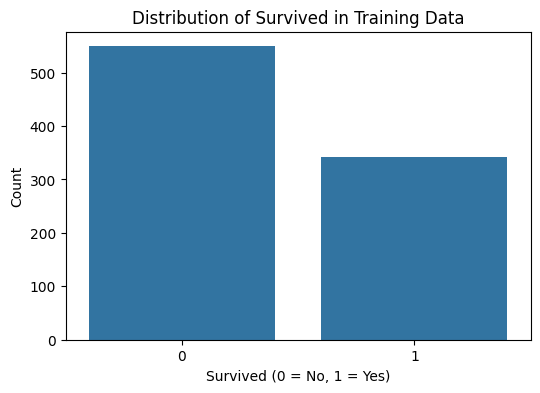

In [ ]:
print("\nDistribution of target variable 'Survived' in Y_train:")
print(Y_train.value_counts(normalize=True))
plt.figure(figsize=(6,4))
sns.countplot(x=Y_train)
plt.title('Distribution of Survived in Training Data')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

## 6. Hyperparameter Tuning & Model Training (XGBoost without SMOTE)

Using `GridSearchCV` with `Accuracy` scoring and without SMOTE on a pipeline.

In [ ]:
print("\nSetting up GridSearchCV for XGBoost (No SMOTE, optimizing for Accuracy)...")

# Define the XGBoost model instance
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # eval_metric for XGBoost internal training

# Define classifier parameters for GridSearchCV
# Note: Prefixes like 'classifier__' are removed as we are not using a pipeline in GridSearchCV here.
# Note: consider a wide range of params for a more in depth search (Add more params will increase time)
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [1],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0.05, 0.1],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0.1, 1.0],
    'min_child_weight': [1, 3]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, # Using xgb_model directly
                           param_grid=param_grid,
                           cv=cv_strategy,
                           scoring='accuracy', # CHANGED for v08
                           n_jobs=1, # Use 1 for sequencial
                           verbose=1)

print("Starting GridSearchCV... This may take several minutes.")
# Ensure X_train and Y_train are available from your preprocessing steps
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_ # This is now a direct XGBClassifier instance

print("\nGridSearchCV Complete.")
print(f"Best Cross-Validation Accuracy Score found: {grid_search.best_score_:.4f}")
print("Best Parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Evaluate on the full training set using the best model
y_train_pred_best_model = best_model.predict(X_train)
train_accuracy_best_model = accuracy_score(Y_train, y_train_pred_best_model)
print(f"\nAccuracy of the best model on the *entire* training set: {train_accuracy_best_model:.4f}")

# For ROC AUC on training set (as a secondary metric)
y_train_pred_proba_best_model = best_model.predict_proba(X_train)[:, 1]
train_roc_auc_best_model = roc_auc_score(Y_train, y_train_pred_proba_best_model)
print(f"ROC AUC of the best model on the *entire* training set: {train_roc_auc_best_model:.4f}")


print("\nTop 15 Feature Importances from the best XGBoost model:")
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(importances.head(15))
else:
    print("Could not retrieve feature importances.")

# Display CV results focusing on accuracy
print("\nCV Results Summary (showing scores):")
results_df = pd.DataFrame(grid_search.cv_results_)
cols_to_show = [col for col in results_df.columns if 'param_' in col or 'split' in col or 'score' in col or 'rank' in col]
# Prioritize mean_test_score and rank_test_score
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score'] + \
               [p for p in param_grid.keys() if f'param_{p}' in results_df.columns]
# Ensure param_ columns are correctly referenced
param_cols_in_results = [f'param_{p}' for p in param_grid.keys()]
display_cols = ['rank_test_score', 'mean_test_score', 'std_test_score'] + param_cols_in_results

# Filter to only existing columns to avoid errors if some params were not varied
existing_display_cols = [col for col in display_cols if col in results_df.columns]

print(results_df[existing_display_cols].sort_values(by='rank_test_score').head(10))


Setting up GridSearchCV for XGBoost (No SMOTE, optimizing for Accuracy)...
Starting GridSearchCV... This may take several minutes.
Fitting 5 folds for each of 512 candidates, totalling 2560 fits

GridSearchCV Complete.
Best Cross-Validation Accuracy Score found: 0.8395
Best Parameters found:
  colsample_bytree: 0.9
  gamma: 0.05
  learning_rate: 0.03
  max_depth: 1
  min_child_weight: 1
  n_estimators: 400
  reg_alpha: 0
  reg_lambda: 0.1
  subsample: 0.8

Accuracy of the best model on the *entire* training set: 0.8361
ROC AUC of the best model on the *entire* training set: 0.8925

Top 15 Feature Importances from the best XGBoost model:
                  Feature  Importance
12             Sex_female    0.188405
16               Title_Mr    0.141042
0                  Pclass    0.106612
1                HasCabin    0.084526
26                 Deck_M    0.047917
6           CabinMultiple    0.044736
38    Pclass_Sex_1_female    0.041940
5       FarePerPerson_log    0.039908
40    Pclass

## 7. Overfitting Analysis (Using Best XGBoost & Accuracy)

### 7.1 Training vs. Cross-Validation Accuracy

In [ ]:
print("\n--- 1. Training vs. Cross-Validation Accuracy ---")
# train_accuracy_best_model calculated in Section 6
cv_accuracy = grid_search.best_score_ # This is the mean CV accuracy from GridSearchCV

print(f"Accuracy on FULL Training Set (using best model): {train_accuracy_best_model:.4f}")
print(f"Best Mean Cross-Validation Accuracy: {cv_accuracy:.4f}")
print(f"Difference (Train Accuracy - CV Accuracy): {train_accuracy_best_model - cv_accuracy:.4f}")

# A typical threshold for accuracy difference might be smaller, e.g., 0.02-0.03
if (train_accuracy_best_model - cv_accuracy) > 0.03:
    print("\nWarning: Potential overfitting detected! Training Accuracy is notably higher than CV Accuracy.")
elif (train_accuracy_best_model - cv_accuracy) < -0.01: # Check for underfitting or issues
    print("\nNote: CV Accuracy is higher than Training Accuracy. This is unusual but can happen with small datasets or specific CV splits. Double-check.")
else:
    print("\nTraining and CV Accuracy are reasonably close. Lower risk of significant overfitting based on this metric.")

best_estimator_index = grid_search.best_index_
cv_std_dev_accuracy = grid_search.cv_results_['std_test_score'][best_estimator_index]
print(f"Standard Deviation of Cross-Validation Accuracy (for best model): {cv_std_dev_accuracy:.4f}")


--- 1. Training vs. Cross-Validation Accuracy ---
Accuracy on FULL Training Set (using best model): 0.8361
Best Mean Cross-Validation Accuracy: 0.8395
Difference (Train Accuracy - CV Accuracy): -0.0034

Training and CV Accuracy are reasonably close. Lower risk of significant overfitting based on this metric.
Standard Deviation of Cross-Validation Accuracy (for best model): 0.0077


### 7.2 Learning Curves (Accuracy)


--- 2. Generating Learning Curves (Accuracy) ---


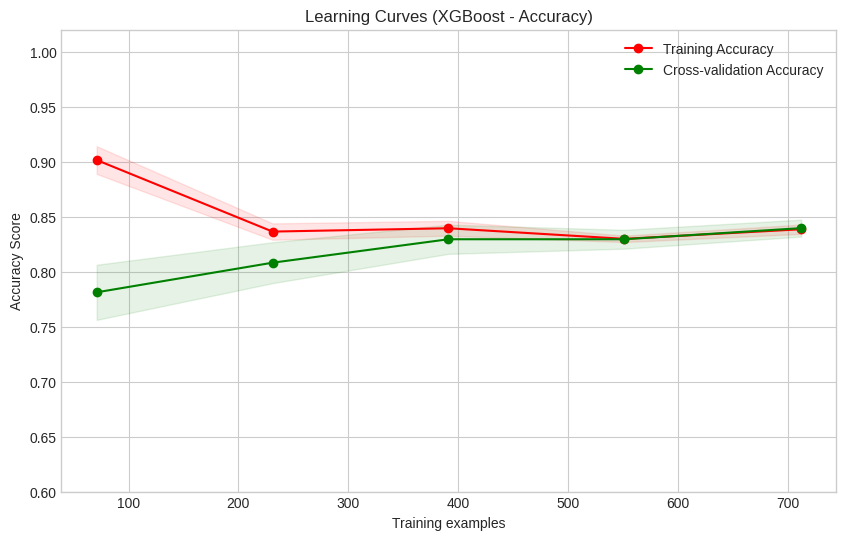

Observe the gap and convergence of training and cross-validation accuracy curves.


In [ ]:
print("\n--- 2. Generating Learning Curves (Accuracy) ---")
# best_model is the direct XGBClassifier instance
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model, # Use the best model (XGBClassifier instance)
    X=X_train,
    y=Y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=cv_strategy,
    scoring='accuracy', # CHANGED for v08
    n_jobs=1,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation Accuracy")
plt.title("Learning Curves (XGBoost - Accuracy)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(0.6, 1.02) # Adjust ylim for accuracy if needed
plt.show()
print("Observe the gap and convergence of training and cross-validation accuracy curves.")

### 7.3 Validation Curve (Example: 'classifier__max_depth', Accuracy)


--- 3. Generating Validation Curve for 'max_depth' (Accuracy) ---


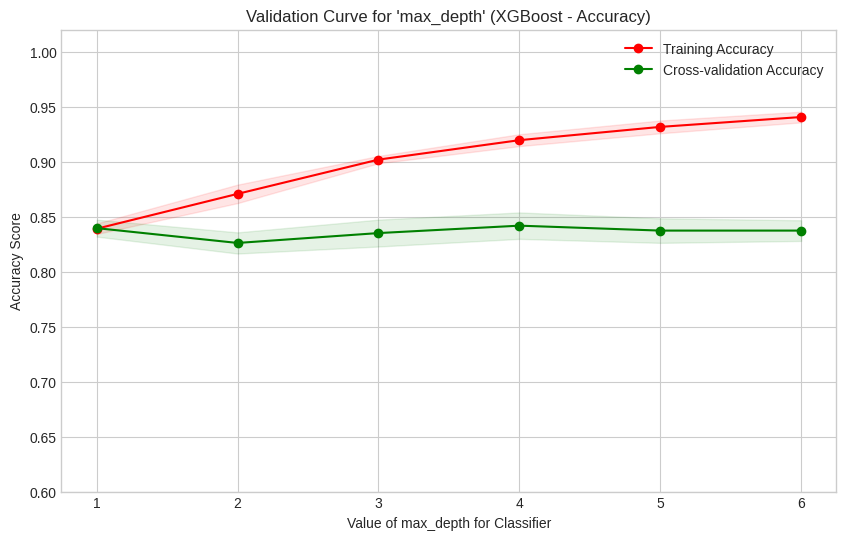

Validation curve plot generated.


In [ ]:
print("\n--- 3. Generating Validation Curve for 'max_depth' (Accuracy) ---")

# Parameter to vary. Ensure it's a parameter of XGBClassifier directly.
param_name_vc = 'max_depth' # No 'classifier__' prefix
param_range_vc = np.arange(1, 7, 1) # Example range for max_depth

# Create a base estimator with other best parameters fixed
# Clone the best_model and then set parameters, or create a new one
# It's often cleaner to create a new one with known fixed params from best_params_
# Ensure all relevant parameters from best_params_ (EXCEPT the one being varied) are set.
base_params_for_vc = grid_search.best_params_.copy()
if param_name_vc in base_params_for_vc:
    del base_params_for_vc[param_name_vc] # Remove the param we are varying

estimator_for_vc = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **base_params_for_vc)

try:
    train_scores_vc, validation_scores_vc = validation_curve(
        estimator=estimator_for_vc,
        X=X_train,
        y=Y_train,
        param_name=param_name_vc,
        param_range=param_range_vc,
        cv=cv_strategy,
        scoring="accuracy", # CHANGED for v08
        n_jobs=1
    )

    train_mean_vc = np.mean(train_scores_vc, axis=1)
    train_std_vc = np.std(train_scores_vc, axis=1)
    valid_mean_vc = np.mean(validation_scores_vc, axis=1)
    valid_std_vc = np.std(validation_scores_vc, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range_vc, train_mean_vc, 'o-', color='r', label='Training Accuracy')
    plt.fill_between(param_range_vc, train_mean_vc - train_std_vc, train_mean_vc + train_std_vc, alpha=0.1, color='r')
    plt.plot(param_range_vc, valid_mean_vc, 'o-', color='g', label='Cross-validation Accuracy')
    plt.fill_between(param_range_vc, valid_mean_vc - valid_std_vc, valid_mean_vc + valid_std_vc, alpha=0.1, color='g')
    plt.title(f"Validation Curve for '{param_name_vc}' (XGBoost - Accuracy)")
    plt.xlabel(f"Value of {param_name_vc} for Classifier")
    plt.ylabel("Accuracy Score")
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(param_range_vc)
    plt.ylim(0.6, 1.02) # Adjust ylim for accuracy
    plt.show()
    print("Validation curve plot generated.")

except Exception as e:
    print(f"Could not generate validation curve for {param_name_vc}: {e}")
    print("This might happen if the parameter range is invalid or conflicts with other fixed parameters.")

### 7.4 Classification Reports & Confusion Matrices (Default threshold 0.5)


--- 4. Classification Reports & Confusion Matrices ---

Classification Report (Full Training Set - Best Model Predictions):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       549
           1       0.81      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.84      0.83       891

Generated cross-validated class predictions.

Classification Report (Cross-Validated Predictions on Train Set - Best Model Predictions):
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



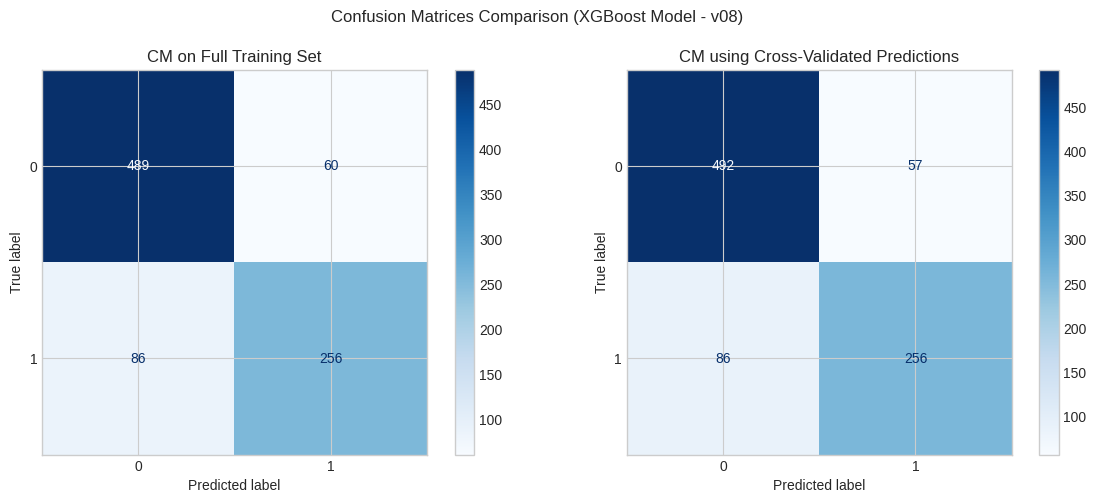

In [ ]:
print("\n--- 4. Classification Reports & Confusion Matrices ---")
# Predictions for classification report (uses 0.5 threshold by default)
# y_train_pred_best_model (class predictions on full train set) already calculated in Section 6

print("\nClassification Report (Full Training Set - Best Model Predictions):")
print(classification_report(Y_train, y_train_pred_best_model, zero_division=0))

try:
    # best_model is the direct XGBClassifier
    y_train_cv_pred_class = cross_val_predict(best_model, X_train, Y_train, cv=cv_strategy, n_jobs=1)
    print("Generated cross-validated class predictions.")

    print("\nClassification Report (Cross-Validated Predictions on Train Set - Best Model Predictions):")
    print(classification_report(Y_train, y_train_cv_pred_class, zero_division=0))

    # Confusion Matrices
    cm_train = confusion_matrix(Y_train, y_train_pred_best_model)
    cm_cv = confusion_matrix(Y_train, y_train_cv_pred_class)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Confusion Matrices Comparison (XGBoost Model - v08)')

    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_model.classes_)
    disp_train.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title('CM on Full Training Set')

    disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=best_model.classes_)
    disp_cv.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title('CM using Cross-Validated Predictions')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Could not generate cross-validated classification reports or confusion matrices: {e}")
    y_train_cv_pred_class = None # Ensure this is defined for safety if the try block fails early

### 7.5 ROC Curve and AUC (Detailed)


--- 5. ROC Curve and AUC (Detailed) ---
AUC on Full Training Set (Best Model): 0.8925
AUC using Cross-Validated Probabilities (Best Model): 0.8723

Train and CV ROC AUC are reasonably close.


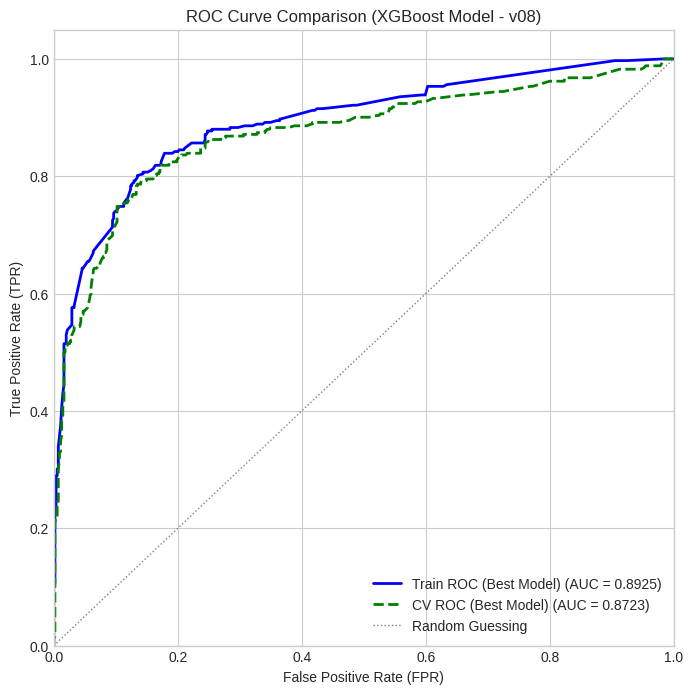

In [ ]:
print("\n--- 5. ROC Curve and AUC (Detailed) ---")
# y_train_pred_proba_best_model (probabilities on full train set) already calculated in Section 6
fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_pred_proba_best_model)
train_auc_val = auc(fpr_train, tpr_train) # Same as train_roc_auc_best_model from Section 6
print(f"AUC on Full Training Set (Best Model): {train_auc_val:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (Best Model) (AUC = {train_auc_val:.4f})')

try:
    # best_model is the direct XGBClassifier
    y_train_cv_proba = cross_val_predict(best_model, X_train, Y_train, cv=cv_strategy, method='predict_proba', n_jobs=1)[:, 1]
    cv_auc_val = roc_auc_score(Y_train, y_train_cv_proba)
    print(f"AUC using Cross-Validated Probabilities (Best Model): {cv_auc_val:.4f}")
    fpr_cv, tpr_cv, _ = roc_curve(Y_train, y_train_cv_proba)
    plt.plot(fpr_cv, tpr_cv, color='green', lw=2, linestyle='--', label=f'CV ROC (Best Model) (AUC = {cv_auc_val:.4f})')

    # Compare Train AUC vs CV AUC for overfitting check (secondary to accuracy check)
    if (train_auc_val - cv_auc_val) > 0.05: # Using a common threshold for AUC difference
         print(f"\nNote: Potential overfitting also suggested by ROC AUC difference (Train AUC: {train_auc_val:.4f}, CV AUC: {cv_auc_val:.4f}).")
    elif (train_auc_val - cv_auc_val) < -0.01:
         print(f"\nNote: CV ROC AUC ({cv_auc_val:.4f}) is higher than Training ROC AUC ({train_auc_val:.4f}). Unusual but possible.")
    else:
         print(f"\nTrain and CV ROC AUC are reasonably close.")

except Exception as e:
    print(f"Could not generate cross_val_predict probabilities for ROC: {e}")

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle=':', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison (XGBoost Model - v08)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 8. Make Predictions on the Test Set

In [ ]:
print("\nMaking predictions on the test set using the best XGBoost pipeline...")
if not X_test.empty:
    predictions = best_model.predict(X_test) # Class predictions
    # predictions_proba = best_model.predict_proba(X_test)[:,1] # Probabilities if needed
    print("Predictions generated.")
    print("First 10 predictions:", predictions[:10])
else:
    print("X_test is empty. Cannot make predictions.")
    predictions = []


Making predictions on the test set using the best XGBoost pipeline...
Predictions generated.
First 10 predictions: [0 1 0 0 1 0 1 0 1 0]


## 9. Create and Download Submission File

In [ ]:
print("\nCreating submission file...")
if len(predictions) > 0:
    submission_df = pd.DataFrame({
        "PassengerId": test_passenger_ids,
        "Survived": predictions
    })
    submission_df['Survived'] = submission_df['Survived'].astype(int)
    submission_filename = 'titanic_prediction_v08.csv'
    submission_df.to_csv(submission_filename, index=False)
    print(f"Submission file '{submission_filename}' created.")
    print(submission_df.head())

    files.download(submission_filename)
    print(f"\nOffering '{submission_filename}' for download (if in Colab)...")
else:
    print("No predictions made, submission file not created.")

print("\n--- Prediction Process Finished (v08) ---")


Creating submission file...
Submission file 'titanic_prediction_v07.csv' created.
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Offering 'titanic_prediction_v07.csv' for download (if in Colab)...

--- Prediction Process Finished (v07) ---
